In [203]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
import math
from sklearn.metrics import mean_squared_error

In [204]:
dataPath = 'Data/'
listOfDataFrames=[]
stations=os.listdir(dataPath)
for station in stations:
    print("Processing year: "+ dataPath +" station: "+station)
    airQualityData=pd.read_csv(dataPath+'\\'+station, header=12,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
    airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
    airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
    airQualityData=airQualityData[(airQualityData['Start']< "2019-09-30 00:00:00")]
    listOfDataFrames.append(airQualityData)
airQualityData= pd.DataFrame(columns= [])
for airData in listOfDataFrames:
    airQualityData=airQualityData.append(airData)
    
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
airQualityData=airQualityData.drop('Stop',axis=1)
airQualityData=airQualityData.set_index('Start',drop= True)
print(airQualityData.shape)

Processing year: Data/ station: shair-18644-1-6-3.csv
Processing year: Data/ station: shair-8779-1-6-3.csv
Processing year: Data/ station: shair-8780-1-6-3.csv
Processing year: Data/ station: shair-8781-1-6-1.csv
(166372, 4)


In [205]:
airQualityData[airQualityData < 0] = 0
airQualityData=airQualityData.interpolate(method ='linear', limit_direction ='forward')
airQualityData.reset_index(drop=True, inplace= True)

In [206]:
new_columns=['predicted_NO2','predicted_NOX','predicted_PM10','predicted_PM2_5']
pre_columns=['NO2','NOX','PM10','PM2_5']
for new_column_name,old_column_name in zip(new_columns,pre_columns):
    airQualityData[new_column_name] = airQualityData[old_column_name].shift(-1)    
airQualityData = airQualityData.drop(airQualityData.tail(1).index)

In [207]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(airQualityData)
data = pd.DataFrame(values)
data.columns = airQualityData.columns

In [213]:
data

,NO2,NOX,PM10,PM2_5,predicted_NO2,predicted_NOX,predicted_PM10,predicted_PM2_5
0,0.050353,0.014125,0.076417,0.188571,0.070588,0.018808,0.042454,0.042857
1,0.070588,0.018808,0.042454,0.042857,0.061647,0.014880,0.046836,0.043810
2,0.061647,0.014880,0.046836,0.043810,0.043765,0.010348,0.041632,0.050476
3,0.043765,0.010348,0.041632,0.050476,0.015059,0.004305,0.044645,0.062857
4,0.015059,0.004305,0.044645,0.062857,0.011765,0.003777,0.038893,0.056190
...,...,...,...,...,...,...,...,...
166366,0.030118,0.005590,0.018077,0.068571,0.029647,0.005363,0.010956,0.063810
166367,0.029647,0.005363,0.010956,0.063810,0.028706,0.005212,0.018899,0.078095
166368,0.028706,0.005212,0.018899,0.078095,0.029176,0.005212,0.021638,0.078095
166369,0.029176,0.005212,0.021638,0.078095,0.028235,0.005136,0.017256,0.072381


In [208]:
train = data.values[:365 * 24 *5*3]
test = data.values[365 * 24 *5*3:]

In [209]:
train_X, train_y = train[:, :-4], train[:, 4:]
test_X, test_y = test[:, :-4], test[:, 4:]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((131400, 1, 4), (131400, 4), (34971, 1, 4), (34971, 4))

In [210]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50,
                    batch_size=72, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False)

Epoch 1/50
1825/1825 - 2s - loss: 0.0457 - val_loss: 0.0194
Epoch 2/50
1825/1825 - 2s - loss: 0.0453 - val_loss: 0.0194
Epoch 3/50
1825/1825 - 2s - loss: 0.0452 - val_loss: 0.0194
Epoch 4/50
1825/1825 - 2s - loss: 0.0452 - val_loss: 0.0194
Epoch 5/50
1825/1825 - 2s - loss: 0.0452 - val_loss: 0.0194
Epoch 6/50
1825/1825 - 2s - loss: 0.0452 - val_loss: 0.0194
Epoch 7/50
1825/1825 - 2s - loss: 0.0452 - val_loss: 0.0194
Epoch 8/50
1825/1825 - 2s - loss: 0.0452 - val_loss: 0.0194
Epoch 9/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 10/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 11/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 12/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 13/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 14/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 15/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 16/50
1825/1825 - 2s - loss: 0.0451 - val_loss: 0.0194
Epoch 17/50
1825/1825 - 2s - loss

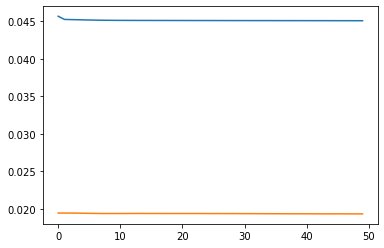

In [211]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

In [212]:
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
'{:.3f}'.format(rmse)

ValueError: operands could not be broadcast together with shapes (34971,4) (8,) (34971,4) 